In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
#packages for DAISY feature detector
from skimage.feature import daisy

from skimage.color import rgb2gray
#packages for sklearn linear regression and SGD
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
#packages for sklearn linear SVR
from sklearn.svm import LinearSVR
#packages for sklearn SVR
from sklearn.svm import SVR, SVC
from sklearn import preprocessing
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, log_loss, precision_recall_fscore_support, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.utils.class_weight import compute_class_weight

In [3]:
def normalizeData(X):
    num_channels = np.shape(X)[1]
    train_mu = np.zeros(num_channels)
    for i in range(num_channels):
        train_mu[i] = np.mean(X[:,i,:,:])
        X[:,i,:,:] = X[:,i,:,:] - train_mu[i]
    return X, train_mu

In [4]:
def normalizeLabels(y):
    mu = np.mean(y,axis=0)
    sigma = np.std(y,axis=0)
    return mu, sigma

In [5]:
def getData():
    X_test = np.load("/home/jacobbedia/data/labels/testimages.npy")
    

    y_test = np.load("/home/jacobbedia/data/labels/testlabels.npy")
    
    
    X_train = np.load('/home/jacobbedia/data/training_images/trainimages.npy')
    y_train = np.load('/home/jacobbedia/data/labels/trainlabels.npy')

    
    X_dev = np.load('/home/jacobbedia/data/training_images/devimages.npy')
    y_dev = np.load('/home/jacobbedia/data/labels/devlabels.npy')
    
       
   
    num_channels = np.shape(X_train)[1]
    
    #uncomment following 4 lines to normalize data
    
    #X_train, train_mu = normalizeData(X_train)
    #for i in range(num_channels):
    #    X_dev[:,i,:,:] = X_dev[:,i,:,:] - train_mu
    #    X_test[:,i,:,:] = X_test[:,i,:,:] - train_mu
        
    num_train = np.shape(X_train)[0]
    num_dev = np.shape(X_dev)[0]
    num_test = np.shape(X_test)[0]
    
    
    
    mu, sigma = normalizeLabels(y_train)
    mu = mu[np.newaxis,:]
    sigma = sigma[np.newaxis,:]
    y_train = (y_train - mu)/sigma
    y_dev = (y_dev - mu)/sigma
    
    y_test = (y_test - mu)/sigma
    
    lymphocytes = [6,9,11,21,22,27,30,34,39,62,63,67,78]
    train_labels_parsed = np.zeros(num_train)[:,np.newaxis]
    dev_labels_parsed = np.zeros(num_dev)[:,np.newaxis]
    test_labels_parsed = np.zeros(num_test)[:,np.newaxis]
    print("markers")
    for marker in lymphocytes:
        print(marker)
        trainmark = y_train[:,marker][:,np.newaxis] > 0
        devmark = y_dev[:,marker][:,np.newaxis] > 0
        testmark = y_test[:,marker][:,np.newaxis] > 0
        train_labels_parsed = train_labels_parsed + trainmark
        dev_labels_parsed = dev_labels_parsed + devmark
        test_labels_parsed = test_labels_parsed + testmark
    
    train_labels_parsed = np.ndarray.flatten(train_labels_parsed > 0)
    dev_labels_parsed = np.ndarray.flatten(dev_labels_parsed > 0)
    test_labels_parsed = np.ndarray.flatten(test_labels_parsed > 0)

    
    


    #train_labels_parsed = keras.utils.to_categorical(train_labels_parsed, num_classes=2)
    #dev_labels_parsed = keras.utils.to_categorical(dev_labels_parsed, num_classes=2)
    #test_labels_parsed = keras.utils.to_categorical(test_labels_parsed, num_classes=2)
    return X_train, train_labels_parsed, X_dev, dev_labels_parsed, X_test, test_labels_parsed

In [6]:
def extractFeaturesDaisy(cell_images):
    num_cells = np.shape(cell_images)[0]
    daisy_matrix = np.zeros((num_cells,200))
    print("Extracting DAISY Features")
    for i in range(num_cells):
        print(i)
        img_orig = rgb2gray(cell_images[i])
        descs = daisy(img_orig)
        flat_descs = descs.flatten()
        daisy_matrix[i] = flat_descs
        if (i%500==0):
            print(i)
    return daisy_matrix

In [7]:
#this method is an old method from milestone regression problem before I pivoted to binning expression levels and classifying

def trainLinearModel(X_train, y_train, X_dev, y_dev, X_test, y_test, marker):
    print("Training linear model")
    num_cells = np.shape(X_train)[0]
    
    intercept = np.ones((num_cells,1))
    X_train = np.append(intercept, X_train, axis=1)
    #linearmodel = linear_model.SGDRegressor(penalty='l2', alpha=0.0, fit_intercept = False, max_iter = 4000, tol = None, learning_rate='constant', eta0=.3)
    linearmodel = linear_model.SGDRegressor(max_iter=10000)
    linearmodel.fit(X_train,y_train)
    
    print("MSE on train set")
    trainpreds = linearmodel.predict(X_train)
    print(mean_squared_error(y_train, trainpreds))
    print("MSE on dev set")
    intercept = np.ones((np.shape(X_dev)[0],1))
    X_dev = np.append(intercept, X_dev, axis=1)
    devpreds = linearmodel.predict(X_dev)
    print(mean_squared_error(y_dev, devpreds))
    return linearmodel

In [8]:
def trainLogisticReg(X_train, y_train, X_dev, y_dev, X_test, y_test, marker):
    print("Training linear model")
    num_cells = np.shape(X_train)[0]
    intercept = np.ones((num_cells,1))
    X_train = np.append(intercept, X_train, axis=1)
    #y_integers = np.argmax(y_train, axis=1)
    #class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    #d_class_weights = dict(enumerate(class_weights))
    d_class_weights = {0:2.3793, 1:.6331}
    print(d_class_weights)
    #linearmodel = linear_model.SGDRegressor(penalty='l2', alpha=0.0, fit_intercept = False, max_iter = 4000, tol = None, learning_rate='constant', eta0=.3)
    linearmodel = linear_model.LogisticRegression(max_iter=30000, class_weight = d_class_weights)
    linearmodel.fit(X_train,y_train)
    print("F1, accuracy, roc train")
    trainpreds = linearmodel.predict(X_train)
    print(f1_score(y_train, trainpreds))
    print(accuracy_score(y_train, trainpreds))
    print(roc_auc_score(y_train, trainpreds))
    
    print("F1, accuracy, roc dev")
    intercept = np.ones((np.shape(X_dev)[0],1))
    X_dev = np.append(intercept, X_dev, axis=1)
    devpreds = linearmodel.predict(X_dev)
    print(f1_score(y_dev, (devpreds>=0)))
    print(accuracy_score(y_dev, devpreds))
    print(roc_auc_score(y_dev, devpreds))
    
    intercept = np.ones((np.shape(X_test)[0],1))
    X_test = np.append(intercept, X_test, axis=1)
    testpreds = linearmodel.predict(X_test)
    print("F1, accuracy, roc test")
    print(f1_score(y_test, testpreds))
    print(accuracy_score(y_test, testpreds))
    print(roc_auc_score(y_test, testpreds))
    #plots(testpreds, y_test)
    return testpreds

In [9]:
def trainlinearSVC(X_train, y_train, X_dev, y_dev, X_test, y_test, marker):
    print("Training SVC model")
    num_cells = np.shape(X_train)[0]
    intercept = np.ones((num_cells,1))
    X_train = np.append(intercept, X_train, axis=1)
    #y_integers = np.argmax(y_train, axis=1)
    #class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    #d_class_weights = dict(enumerate(class_weights))
    d_class_weights = {0:2.3793, 1:.6331}
    print(d_class_weights)
    #linearmodel = linear_model.SGDRegressor(penalty='l2', alpha=0.0, fit_intercept = False, max_iter = 4000, tol = None, learning_rate='constant', eta0=.3)
    SVCmodel = SVC(C=1.0, kernel='linear', max_iter=5000, verbose=True, class_weight = d_class_weights)
    SVCmodel.fit(X_train,y_train)
    print("F1, accuracy, roc train")
    trainpreds = SVCmodel.predict(X_train)
    print(f1_score(y_train, trainpreds))
    print(accuracy_score(y_train, trainpreds))
    print(roc_auc_score(y_train, trainpreds))
    
    print("F1, accuracy, roc dev")
    intercept = np.ones((np.shape(X_dev)[0],1))
    X_dev = np.append(intercept, X_dev, axis=1)
    devpreds = SVCmodel.predict(X_dev)
    print(f1_score(y_dev, (devpreds)))
    print(accuracy_score(y_dev, devpreds))
    print(roc_auc_score(y_dev, devpreds))
    
    intercept = np.ones((np.shape(X_test)[0],1))
    X_test = np.append(intercept, X_test, axis=1)
    testpreds = SVCmodel.predict(X_test)
    print("F1, accuracy, roc test")
    print(f1_score(y_test, (testpreds)))
    print(accuracy_score(y_test, testpreds))
    print(roc_auc_score(y_test, testpreds))
    #plots(testpreds, y_test)
    return testpreds

In [10]:
def trainpolySVC(X_train, y_train, X_dev, y_dev, X_test, y_test, marker):
    print("Training poly SVC model")
    num_cells = np.shape(X_train)[0]
    intercept = np.ones((num_cells,1))
    X_train = np.append(intercept, X_train, axis=1)
    #y_integers = np.argmax(y_train, axis=1)
    #class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    #d_class_weights = dict(enumerate(class_weights))
    d_class_weights = {0:2.3793, 1:.6331}
    print(d_class_weights)
    #linearmodel = linear_model.SGDRegressor(penalty='l2', alpha=0.0, fit_intercept = False, max_iter = 4000, tol = None, learning_rate='constant', eta0=.3)
    SVCmodel = SVC(C=1.0, kernel='poly', max_iter=5000, verbose=True, class_weight = d_class_weights)
    SVCmodel.fit(X_train,y_train)
    print("F1, accuracy, roc train")
    trainpreds = SVCmodel.predict(X_train)
    print(f1_score(y_train, trainpreds))
    print(accuracy_score(y_train, trainpreds))
    print(roc_auc_score(y_train, trainpreds))
    
    print("F1, accuracy, roc dev")
    intercept = np.ones((np.shape(X_dev)[0],1))
    X_dev = np.append(intercept, X_dev, axis=1)
    devpreds = SVCmodel.predict(X_dev)
    print(f1_score(y_dev, devpreds))
    print(accuracy_score(y_dev, (devpreds) ))
    print(roc_auc_score(y_dev, devpreds))
    
    intercept = np.ones((np.shape(X_test)[0],1))
    X_test = np.append(intercept, X_test, axis=1)
    testpreds = SVCmodel.predict(X_test)
    
    print("F1, accuracy, roc test")
    print(f1_score(y_test, (testpreds>=0)))
    print(accuracy_score(y_test, testpreds))
    print(roc_auc_score(y_test, testpreds))
    #plots(testpreds, y_test)
    
    return testpreds

In [11]:
def trainKernelizedRidge(trainset):
    num_cells = np.shape(trainset)[0]
    y_train = trainset[:,-1]
    X_train = trainset[:,0:-1]
    print("sizes")
    print(np.shape(y_train))
    print(np.shape(X_train))
    intercept = np.ones((num_cells,1))
    #X_train = np.append(intercept, X_train, axis=1)
    model = KernelRidge()
    model.fit(X_train,y_train)
    print("score")
    print(model.score(X_train,y_train))
    preds = model.predict(X_train)
    print(preds)
    print(y_train)

In [12]:
def trainSVR(trainset, marker):
    num_cells = np.shape(trainset)[0]
    y_train = trainset[:,1800+marker]
    X_train = trainset[:,0:1800]
    intercept = np.ones((num_cells,1))
    #X_train = np.append(intercept, X_train, axis=1)
    
    CD3_SVR_model = SVR(max_iter=4000)
    CD3_SVR_model.fit(X_train, y_train)
    print(CD3_SVR_model.score(X_train, y_train))

In [34]:
def main():
    
    X_train, y_train, X_dev, y_dev, X_test, y_test = getData()
    
    #ONLY UNCOMMENT FOR DAISY FEATURE EXTRACTION
    #DAISY_train = extractFeaturesDaisy(X_train)
    #np.save("/home/jacobbedia/data/DAISYfeatures/DAISY_train", DAISY_train)
    #DAISY_dev = extractFeaturesDaisy(X_dev)
    #np.save("/home/jacobbedia/data/DAISYfeatures/DAISY_dev", DAISY_dev)
    #DAISY_test = extractFeaturesDaisy(X_test.astype(np.uint8))
    #np.save("/home/jacobbedia/data/DAISYfeatures/DAISY_test", DAISY_test)
    

    X_train = np.load("/home/jacobbedia/data/DAISYfeatures/DAISY_train.npy")
    X_dev = np.load("/home/jacobbedia/data/DAISYfeatures/DAISY_dev.npy")
    X_test = np.load("/home/jacobbedia/data/DAISYfeatures/DAISY_test.npy")
    
    predictions = trainLogisticReg(X_train, y_train, X_dev, y_dev, X_test, y_test, 0)
    linSVCpreds = trainlinearSVC(X_train, y_train, X_dev, y_dev, X_test, y_test, 0)
    predictions = np.append(predictions[:,np.newaxis], linSVCpreds[:,np.newaxis], axis=1)
    polySVCpreds = trainpolySVC(X_train, y_train, X_dev, y_dev, X_test, y_test, 0)
    predictions = np.append(predictions, polySVCpreds[:,np.newaxis], axis=1)

    np.save("/home/jacobbedia/data/baseline_model_predictions", predictions)
    
    plots(y_test)

In [41]:
def plots(normCD3test):
    finalprediction_list = np.load("/home/jacobbedia/data/baseline_model_predictions.npy")
    model_list = ["Logistic Regression", "Linear SVM", "Polynomial SVM"]
    
    plt.figure(1)   
    metrics = np.zeros((3,4))
    for i in range(3):
        #met = [score, prec, recall]
        roc_AUC = roc_auc_score(normCD3test, finalprediction_list[:, i])
        print("roc_AUC")
        print(roc_AUC)
        y_for_AUC = normCD3test
        fpr, tpr, thresholds = roc_curve(y_for_AUC, finalprediction_list[:, i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label='{}(area = {:.3f})'.format(model_list[i], roc_AUC))
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.savefig("/home/jacobbedia/data/baselineROCcurveNNresnet2032.pdf", dpi=1000)
    plt.show()
    plt.close()
    plt.figure(1)
    metrics = np.zeros((3,4))
    for i in range(3): 
        y_for_AUC = normCD3test
        pred_for_AUC = finalprediction_list[:, i]
        
        precmatrix, recallmatrix, thresholds = precision_recall_curve(y_for_AUC, pred_for_AUC)
        score = f1_score(y_for_AUC, pred_for_AUC)
        print("scores{} {}".format(model_list[i], score))
        step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
        lab = '{} (F1 = {})'.format(model_list[i], score)
        plt.step(recallmatrix, precmatrix, label=lab, where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc='best')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.savefig("/home/jacobbedia/data/baselineoptimprec_reccurveNNresnet2032.pdf", dpi=1000)
    plt.show()
    plt.close()

mu_shape
(1, 92)
sigma
(1, 92)
(58631, 92)
(58631, 92)
markers
6
9
11
21
22
27
30
34
39
62
63
67
78
wow
0.7898551960566935
0.7915131668713331
0.7853664061615132


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


roc_AUC
0.5184000599698781
roc_AUC
0.5
roc_AUC
0.5


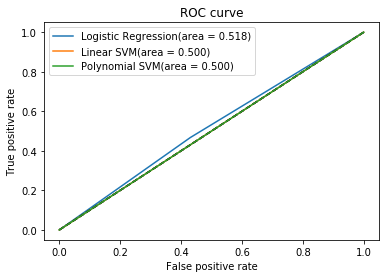

scoresLogistic Regression 0.5897552542989718
scoresLinear SVM 0.0
scoresPolynomial SVM 0.0


/home/shared/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


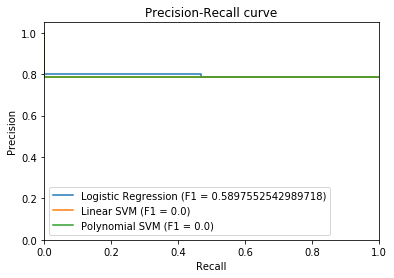

In [42]:
if __name__ == "__main__":
    main()